# Описание проекта. Телеком  
Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.

### Описание услуг  
Оператор предоставляет два основных типа услуг:  
Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
Интернет. Подключение бывает двух типов: через телефонную линию DSL (англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (англ. fiber optic).  
Также абонентам доступен ряд услуг:  
Интернет-безопасность: антивирус (Device Protection) и блокировка опасных сайтов (Online Security);  
Выделенная линия технической поддержки (Tech Support);  
Облачное хранилище файлов для резервного копирования данных (Online Backup);  
Стриминговое телевидение (Streaming TV) и каталог фильмов (Streaming Movies).  
За услуги клиенты могут платить ежемесячно или раз в 1–2 года.  
Доступны различные способы расчёта и возможность получить электронный чек.  
### Описание данных
Данные хранятся в базе данных PostgreSQL. Она состоит из нескольких таблиц:  
contract — информация о договорах;  
personal — персональные данные клиентов;  
internet — информация об интернет-услугах;  
phone — информация об услугах телефонии. 

Таблица `telecom.contract`   
customerID — ID абонента;  
BeginDate — дата начала действия договора;  
EndDate — дата окончания действия договора;  
Type — тип оплаты: раз в год-два или ежемесячно;  
PaperlessBilling — электронный расчётный лист;  
PaymentMethod — тип платежа;  
MonthlyCharges — расходы за месяц;  
TotalCharges — общие расходы абонента.  

Таблица `telecom.personal`  
customerID — ID пользователя;  
gender — пол;  
SeniorCitizen — является ли абонент пенсионером;  
Partner — есть ли у абонента супруг или супруга;  
Dependents — есть ли у абонента дети.  

Таблица `telecom.internet`   
customerID — ID пользователя;  
InternetService — тип подключения;  
OnlineSecurity — блокировка опасных сайтов;  
OnlineBackup — облачное хранилище файлов для резервного копирования данных;  
DeviceProtection — антивирус;  
TechSupport — выделенная линия технической поддержки;  
StreamingTV — стриминговое телевидение;  
StreamingMovies — каталог фильмов.  

Таблица `telecom.phone`  
customerID — ID пользователя;  
MultipleLines — подключение телефона к нескольким линиям одновременно.  

Информация о договорах актуальна на 1 февраля 2020.

## Импорт библиотек и загрузка данных

### Импорт библиотек

In [1]:
!pip install phik

In [2]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns
import phik
from scipy.stats import shapiro
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_recall_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from catboost import CatBoostClassifier
from sklearn.utils import class_weight
from sklearn.neural_network import MLPClassifier
import warnings
from sqlalchemy import create_engine
import psycopg2
RANDOM_STATE = 22823

### Загрузка данных

In [3]:
db_config = {
            'user': 'praktikum_student', # Имя пользователя
            'pwd': 'Sdf4$2;d-d30pp', # Пароль
            'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net', # Хост
            'port': 6432, # Порт подключения
            'db': 'data-science-final' # Название базы данных,
            }

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
) 

engine = create_engine(connection_string)

In [4]:
    query_contract = "SELECT * FROM telecom.contract"
    query_personal = "SELECT * FROM telecom.personal"
    query_internet = "SELECT * FROM telecom.internet"
    query_phone = "SELECT * FROM telecom.phone"
    
    contract_df = pd.read_sql(query_contract, engine)
    personal_df = pd.read_sql(query_personal, engine)
    internet_df = pd.read_sql(query_internet, engine)
    phone_df = pd.read_sql(query_phone, engine)

In [5]:
contract_df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65


In [6]:
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           1869 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


In [7]:
personal_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [8]:
personal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [9]:
internet_df.head()

,c1,c2,c3,c4,c5,c6,c7,c8
0,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No


In [10]:
internet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5518 entries, 0 to 5517
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   c1      5518 non-null   object
 1   c2      5518 non-null   object
 2   c3      5518 non-null   object
 3   c4      5518 non-null   object
 4   c5      5518 non-null   object
 5   c6      5518 non-null   object
 6   c7      5518 non-null   object
 7   c8      5518 non-null   object
dtypes: object(8)
memory usage: 345.0+ KB


In [11]:
internet_df.head()

,c1,c2,c3,c4,c5,c6,c7,c8
0,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No


In [12]:
internet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5518 entries, 0 to 5517
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   c1      5518 non-null   object
 1   c2      5518 non-null   object
 2   c3      5518 non-null   object
 3   c4      5518 non-null   object
 4   c5      5518 non-null   object
 5   c6      5518 non-null   object
 6   c7      5518 non-null   object
 7   c8      5518 non-null   object
dtypes: object(8)
memory usage: 345.0+ KB


In [13]:
phone_df.head()

,c1,c2
0,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes


In [14]:
phone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362 entries, 0 to 6361
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   c1      6362 non-null   object
 1   c2      6362 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Считали данные
4 таблицы, во всех таблицах надо изменить название столбца 'customerID' на 'CustomerID'
`contract_df` в столбце EndDate заменить пропуски на `01.02.2020`, перевести в в формат даты, как и  `BeginDate` , но до этого из `contract_df` вытянуть данные с значением , none, поскольку это целевой признак


## Предобработка данных

Создадим новый столбец с целевым признаком `Target` Если человек перестал пользоваться услугами то укажем `1`, если полузуется то `0`

In [15]:
contract_df['Target'] = contract_df['EndDate'].apply(lambda x: 0 if x is None else 1)

Удаляем пустые строки в столбце `TotalCharges`, их там всего 11, думаю это не сильно повлияет на результат

In [16]:
contract_df = contract_df.dropna(subset=['TotalCharges'])

Заменим пропуски с столбце `EndDate` на на 1 февраля 2020.

In [17]:
contract_df['EndDate'].fillna('01-02-2020', inplace=True)

изменим тип данных в столбцах которые несут дату

In [18]:
contract_df['EndDate'] = pd.to_datetime(contract_df['EndDate'])
contract_df['BeginDate'] = pd.to_datetime(contract_df['BeginDate'])

Создадим столбец с далительностю пользования услугами, думаюю это интересный столбец 

In [19]:
contract_df['Used'] = (contract_df['EndDate'] - contract_df['BeginDate']).dt.days

In [20]:
contract_df['Used'] = contract_df['Used'].apply(lambda x: max(x, 0))

В таблицах phone_df и internet_df попроваим названия столбцов

In [21]:
new_columns = internet_df.iloc[0]
internet_df.columns = new_columns
internet_df = internet_df[1:]

In [22]:
new_columns_phone = phone_df.iloc[0]
phone_df.columns = new_columns_phone
phone_df = phone_df[1:]

Приведем customerID вов сех таблицах к стандартному виду


In [23]:
contract_df.rename(columns={'customerID': 'CustomerID'}, inplace=True)
personal_df.rename(columns={'customerID': 'CustomerID'}, inplace=True)
internet_df.rename(columns={'customerID': 'CustomerID'}, inplace=True)
phone_df.rename(columns={'customerID': 'CustomerID'}, inplace=True)

Соеденим все в одну таблицу

In [24]:
df = contract_df.merge(personal_df, on='CustomerID', how='left')
df = df.merge(internet_df, on='CustomerID', how='left')
df = df.merge(phone_df, on='CustomerID', how='left')

Еще не много подчистим пропуска

In [25]:
df['MultipleLines'].unique()

array(['No', 'Yes', nan], dtype=object)

In [26]:
df.fillna('No', inplace=True)

In [27]:
df.replace({'Yes': 1, 'No': 0}, inplace=True)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           7032 non-null   datetime64[ns]
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   int64         
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   Target            7032 non-null   int64         
 9   Used              7032 non-null   int64         
 10  gender            7032 non-null   object        
 11  SeniorCitizen     7032 non-null   int64         
 12  Partner           7032 non-null   int64         
 13  Dependents        7032 non-null   int64         
 14  InternetService   7032 n

In [29]:
df.head()

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Target,Used,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,1,479,...,0,0,DSL,1,1,0,0,0,0,0
1,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,1,279,...,0,0,Fiber optic,0,0,0,0,0,0,0
2,9305-CDSKC,2018-12-26,2019-11-01,Month-to-month,1,Electronic check,99.65,820.50,1,310,...,0,0,Fiber optic,0,0,1,0,1,1,1
3,7892-POOKP,2019-04-27,2019-11-01,Month-to-month,1,Electronic check,104.80,3046.05,1,188,...,1,0,Fiber optic,0,0,1,1,1,1,1
4,0280-XJGEX,2018-11-13,2019-10-01,Month-to-month,1,Bank transfer (automatic),103.70,5036.30,1,322,...,0,0,Fiber optic,0,1,1,0,1,1,1


### Выводы:

1. Создали столбец таргет с целевым признаком
2. Избавились от пропусков  
3. Создали столбец с длительностью пользования услугами  
4. Поравили названия столбцов  
5. Собрали все в одну общую таблицу

## Анализ данных

### Построим графики, ознакомимся с зависимостями

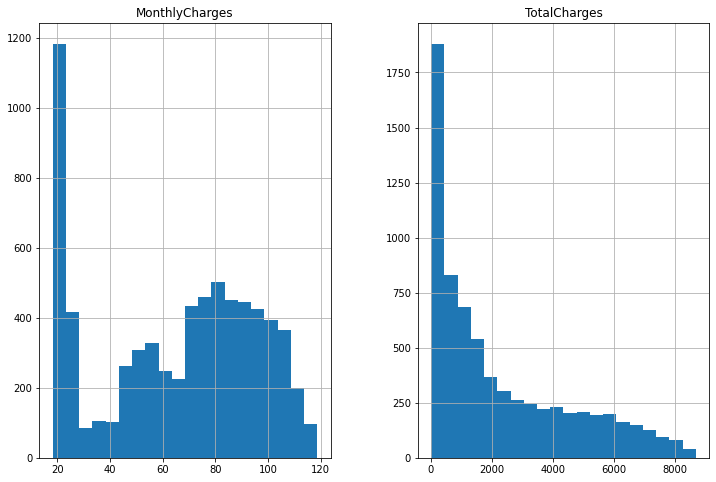

In [30]:
numerical_features = ['MonthlyCharges', 'TotalCharges']
df[numerical_features].hist(bins=20, figsize=(12, 8))
plt.show()

можно ознакомится с распределением расходов по месяцам  и общие расходы пользователей

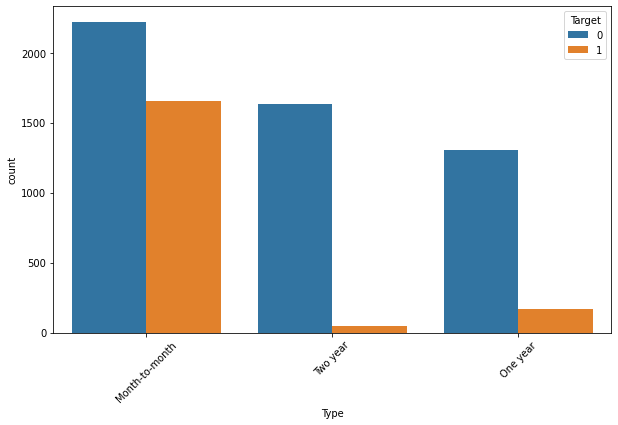

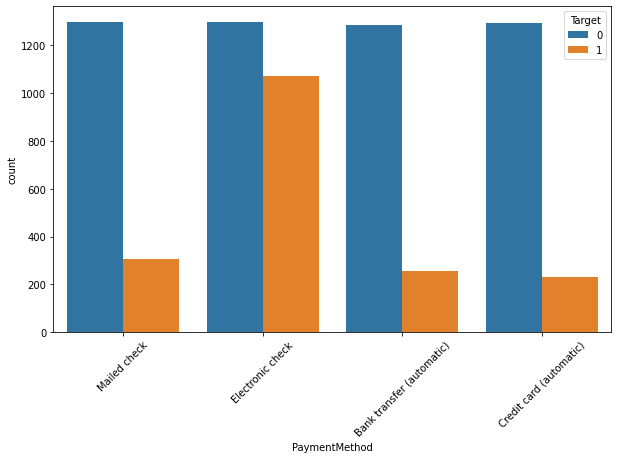

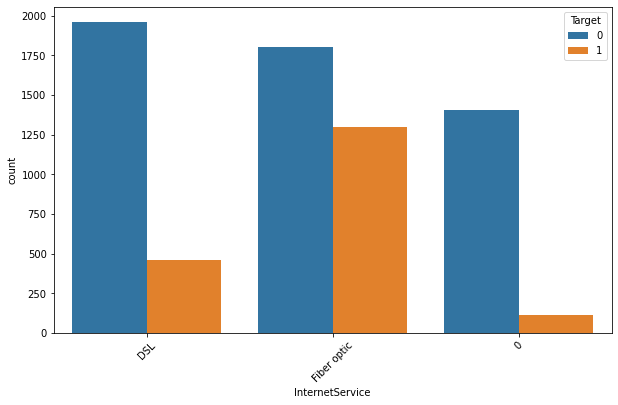

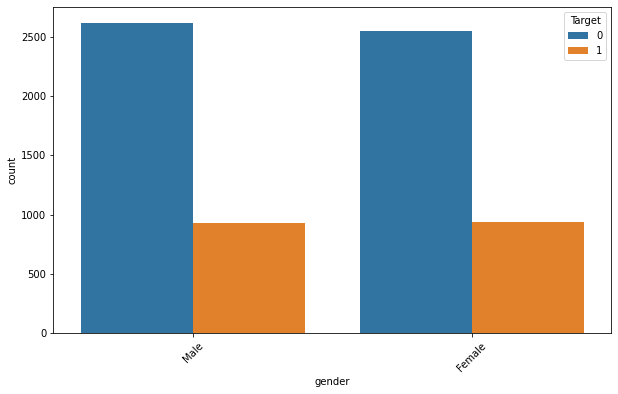

In [31]:
categorical_features = ['Type', 'PaymentMethod', 'InternetService', 'gender']
for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=feature, hue='Target')
    plt.xticks(rotation=45)
    plt.show()

На первом графике показано распределение типов платежа, а так же перестал ли человек пользоваться услугами  
На втором графике тип оплаты  
на третьем тип подключение интернета или подключен ли он вообще  
на четвертом пол клиента

In [32]:
# num_features = ['SeniorCitizen', 'Partner', 'Dependents', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
#                 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']
# for feature in num_features:
#     plt.figure(figsize=(10, 6))
#     sns.countplot(data=df, x=feature, hue='Target')
#     plt.xticks(rotation=45)
#     plt.show()

Посмотрим на корреляцию признаков

In [33]:
# correlation_matrix = df.corr()
# plt.figure(figsize=(12, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
# plt.show()

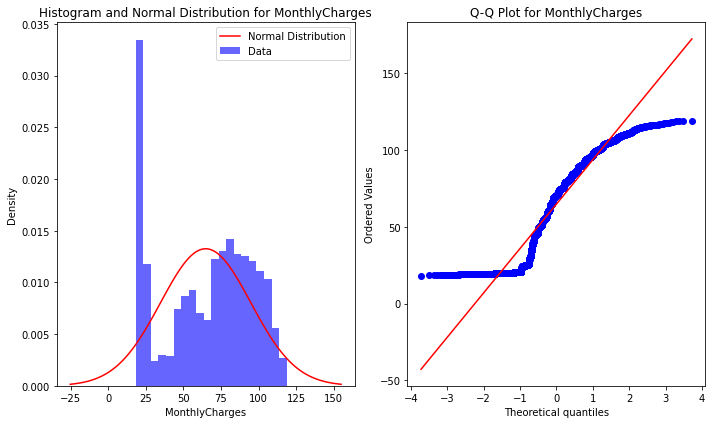

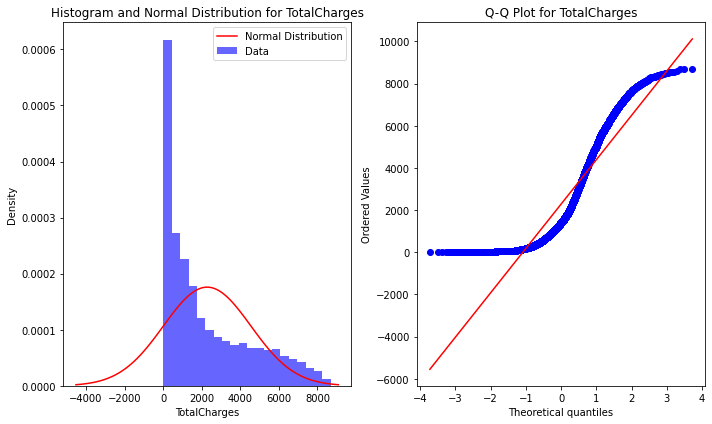

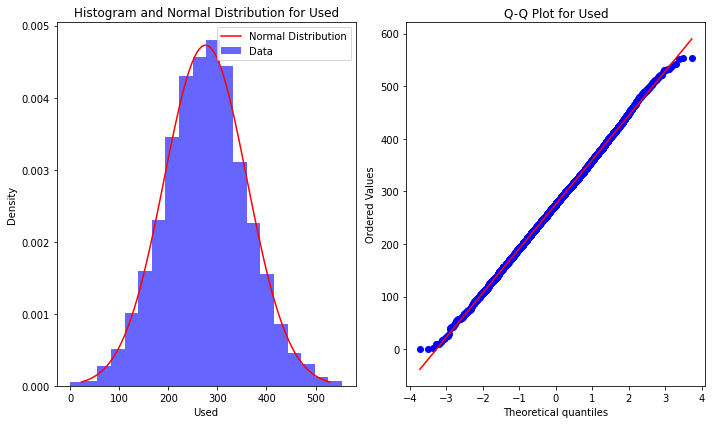

In [34]:
columns_to_check = ['MonthlyCharges', 'TotalCharges', 'Used']

for column in columns_to_check:
    plt.figure(figsize=(10, 6))
    
    plt.subplot(1, 2, 1)
    plt.hist(df[column], bins=20, density=True, alpha=0.6, color='b', label='Data')
    mu, sigma = df[column].mean(), df[column].std()
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), color='r', label='Normal Distribution')
    plt.title(f'Histogram and Normal Distribution for {column}')
    plt.xlabel(column)
    plt.ylabel('Density')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    stats.probplot(df[column], plot=plt)
    plt.title(f'Q-Q Plot for {column}')
    
    plt.tight_layout()
    plt.show()



interval columns not set, guessing: ['PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'Target', 'Used', 'SeniorCitizen', 'Partner', 'Dependents', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']


/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable CustomerID is large: 7032. Are you sure this is not an interval variable? Analysis for pairs of variables including CustomerID can be slow.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/bivariate.py:241: UserWarning: Many cells: 3614448. Are interval variables set correctly?
  warnings.warn(


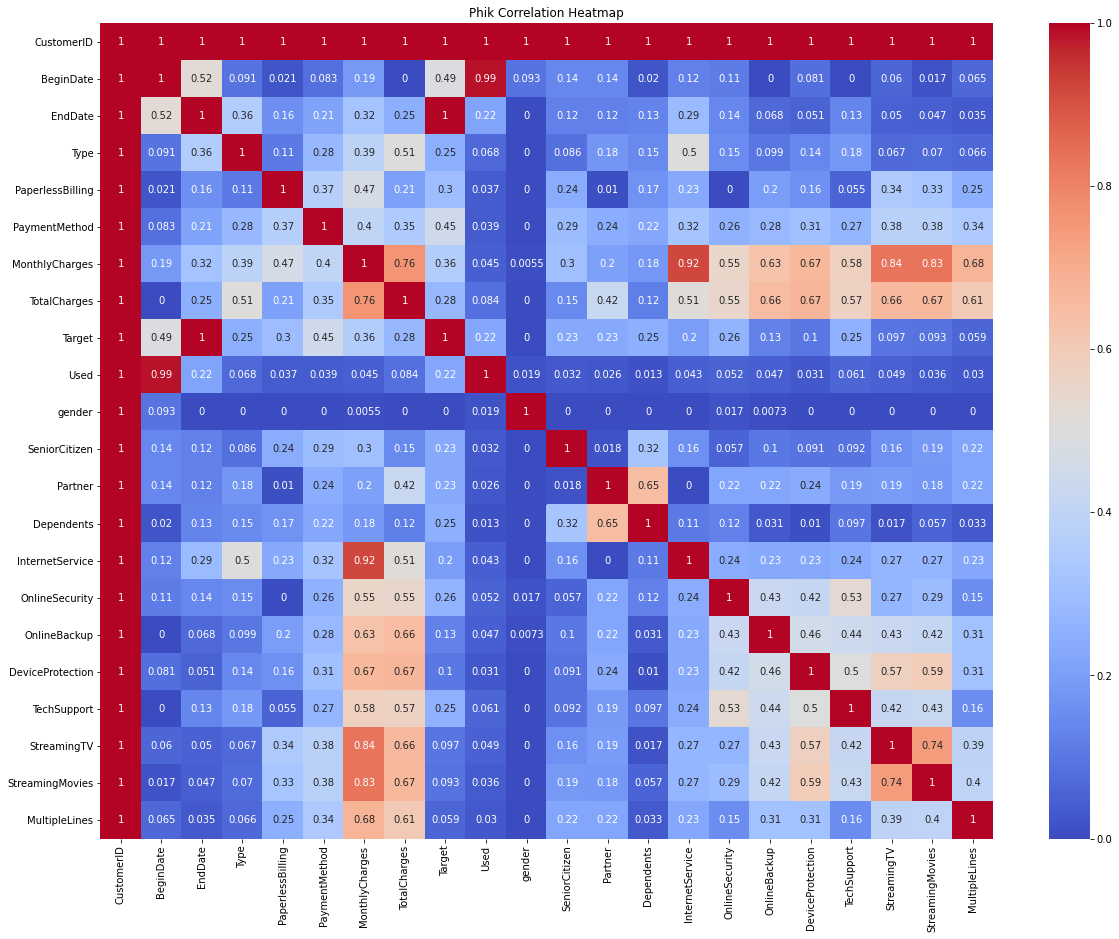

In [35]:
correlation_matrix_phik = df.phik_matrix()

# Построение тепловой карты для корреляции phik
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix_phik, annot=True, cmap='coolwarm')
plt.title("Phik Correlation Heatmap")
plt.show()

Видна сильная зависимость суммы оплаты от подключеных  услуг

In [36]:
df.describe()

,PaperlessBilling,MonthlyCharges,TotalCharges,Target,Used,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.592719,64.798208,2283.300441,0.265785,275.821815,0.162400,0.482509,0.298493,0.286547,0.344852,0.343857,0.290102,0.384386,0.388367,0.421928
std,0.491363,30.085974,2266.771362,0.441782,84.341784,0.368844,0.499729,0.457629,0.452180,0.475354,0.475028,0.453842,0.486484,0.487414,0.493902
min,0.000000,18.250000,18.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,35.587500,401.450000,0.000000,220.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,70.350000,1397.475000,0.000000,276.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,89.862500,3794.737500,1.000000,331.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,118.750000,8684.800000,1.000000,554.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Посмотрим распределение целевого признака

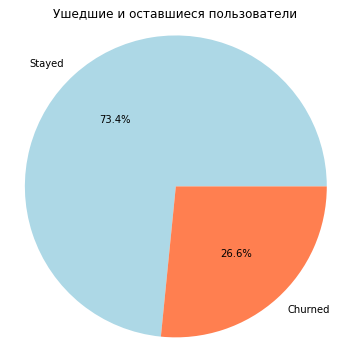

In [37]:
target_counts = df['Target'].value_counts()
labels = ['Stayed', 'Churned']
colors = ['lightblue', 'coral']

plt.figure(figsize=(6, 6))
plt.pie(target_counts, labels=labels, colors=colors, autopct='%1.1f%%')
plt.title('Ушедшие и оставшиеся пользователи')
plt.axis('equal')
plt.show()

In [38]:
df['InternetService'] = df['InternetService'].replace(0, 'no')

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           7032 non-null   datetime64[ns]
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   int64         
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   Target            7032 non-null   int64         
 9   Used              7032 non-null   int64         
 10  gender            7032 non-null   object        
 11  SeniorCitizen     7032 non-null   int64         
 12  Partner           7032 non-null   int64         
 13  Dependents        7032 non-null   int64         
 14  InternetService   7032 n

## Обучение моделей

In [40]:
# selected_features = [
#     'Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges',
#     'Used', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
#     'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
#     'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines'
# ]

# # Извлекаем только выбранные признаки
# selected_df = df[selected_features]

# # Применяем One-Hot Encoding к категориальным переменным
# categorical_columns = ['Type', 'PaymentMethod', 'gender', 'InternetService']
# ohe = OneHotEncoder(drop='first', sparse=False)  # drop='first' чтобы избежать дамми-ловушки

# encoded_categorical = ohe.fit_transform(selected_df[categorical_columns])
# encoded_df = pd.DataFrame(encoded_categorical, columns=ohe.get_feature_names(categorical_columns))

# # Объединяем закодированные признаки с остальными
# X = pd.concat([selected_df.drop(categorical_columns, axis=1), encoded_df], axis=1)
# y = df['Target']

In [41]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)


In [42]:
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [43]:
selected_features = [
    'Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges',
    'Used', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines'
]

# Извлекаем только выбранные признаки
selected_df = df[selected_features]

# Разбиваем на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(selected_df, df['Target'], test_size=0.2, random_state=RANDOM_STATE)

# Отделяем категориальные признаки для кодирования
categorical_columns = ['Type', 'PaymentMethod', 'gender', 'InternetService']

# Применяем One-Hot Encoding к категориальным переменным на тренировочной выборке
ohe = OneHotEncoder(drop='first', sparse=False)
encoded_categorical = ohe.fit_transform(X_train[categorical_columns])
encoded_columns = ohe.get_feature_names(categorical_columns)
encoded_df_train = pd.DataFrame(encoded_categorical, columns=encoded_columns, index=X_train.index)

# Применяем One-Hot Encoding на тестовой выборке
encoded_categorical_test = ohe.transform(X_test[categorical_columns])
encoded_df_test = pd.DataFrame(encoded_categorical_test, columns=encoded_columns, index=X_test.index)

# Соединяем закодированные признаки с остальными для обеих выборок
X_train_encoded = pd.concat([X_train.drop(categorical_columns, axis=1), encoded_df_train], axis=1)
X_test_encoded = pd.concat([X_test.drop(categorical_columns, axis=1), encoded_df_test], axis=1)

# Применяем стандартизацию
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

In [44]:
print("Размер тренировочной выборки (X_train_scaled):", X_train_scaled.shape)
print("Размер тестовой выборки (X_test_scaled):", X_test_scaled.shape)
print("Размер тренировочной выборки (y_train):", y_train.shape)
print("Размер тестовой выборки (y_test):", y_test.shape)

Размер тренировочной выборки (X_train_scaled): (5625, 22)
Размер тестовой выборки (X_test_scaled): (1407, 22)
Размер тренировочной выборки (y_train): (5625,)
Размер тестовой выборки (y_test): (1407,)


У нас имеется дисбаланс, поэтому будем использовать параметр class_weight

### RandomForest

In [45]:
class_weights = class_weight.compute_class_weight('balanced', classes=[0, 1], y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# Создание модели случайного леса
rf_model = RandomForestClassifier(class_weight=class_weight_dict, random_state=RANDOM_STATE)

# Подготовка параметров для GridSearchCV
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
}

# Создание объекта GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, scoring='roc_auc', cv=5)

# Обучение модели с использованием GridSearchCV
grid_search_rf.fit(X_train_scaled, y_train)

# Получение лучшей модели
best_rf_model = grid_search_rf.best_estimator_

# Сравнение моделей на основе grid.best_score_
roc_auc_best_rf = grid_search_rf.best_score_

print("Лучшие параметры для случайного леса:", grid_search_rf.best_params_)
print("ROC-AUC для случайного леса на кросс-валидации:", roc_auc_best_rf)

Лучшие параметры для случайного леса: {'max_depth': 10, 'n_estimators': 200}
ROC-AUC для случайного леса на кросс-валидации: 0.849558631660605


### CatBoost

In [46]:
%%time

class_weights = class_weight.compute_class_weight('balanced', classes=[0, 1], y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# Создание модели CatBoost
catboost_model = CatBoostClassifier(class_weights=class_weight_dict, random_state=RANDOM_STATE, verbose=False)

# Подготовка параметров для GridSearchCV
param_grid_catboost = {
    'iterations': [100, 200],
    'depth': [4, 6],
}

# Создание объекта GridSearchCV
grid_search_catboost = GridSearchCV(estimator=catboost_model, param_grid=param_grid_catboost, scoring='roc_auc', cv=5)

# Обучение модели с использованием GridSearchCV
grid_search_catboost.fit(X_train_scaled, y_train)

# Получение лучшей модели
best_catboost_model = grid_search_catboost.best_estimator_

# Прогнозирование вероятностей на тренировочных данных
y_pred_train_catboost = best_catboost_model.predict_proba(X_train_scaled)[:, 1]
roc_auc_train_catboost = grid_search_catboost.best_score_

print("Лучшие параметры для CatBoost:", grid_search_catboost.best_params_)
print("ROC-AUC для CatBoost на тренировочных данных:", roc_auc_train_catboost)

Лучшие параметры для CatBoost: {'depth': 4, 'iterations': 100}
ROC-AUC для CatBoost на тренировочных данных: 0.8516790091737618
CPU times: user 8.35 s, sys: 390 ms, total: 8.74 s
Wall time: 24.3 s


### Нейронка

In [47]:
%time


# Создание модели нейронной сети
nn_model = MLPClassifier(random_state=RANDOM_STATE)

# Подготовка параметров для GridSearchCV
param_grid_nn = {
    'hidden_layer_sizes': [(50,), (100,)],
}

# Создание объекта GridSearchCV
grid_search_nn = GridSearchCV(estimator=nn_model, param_grid=param_grid_nn, scoring='roc_auc', cv=3)

# Обучение модели с использованием GridSearchCV
grid_search_nn.fit(X_train_scaled, y_train)

# Получение лучшей модели
best_nn_model = grid_search_nn.best_estimator_

# Прогнозирование вероятностей на тренировочных данных
y_pred_train_nn = best_nn_model.predict_proba(X_train_scaled)[:, 1]
roc_auc_train_nn =  grid_search_nn.best_score_

print("Лучшие параметры для нейронной сети:", grid_search_nn.best_params_)
print("ROC-AUC для нейронной сети на тренировочных данных:", roc_auc_train_nn)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.48 µs


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:

Лучшие параметры для нейронной сети: {'hidden_layer_sizes': (50,)}
ROC-AUC для нейронной сети на тренировочных данных: 0.831426723849817


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [48]:
print("ROC-AUC для случайного леса на тренировочных данных:", roc_auc_best_rf)
print("ROC-AUC для CatBoost на тренировочных данных:", roc_auc_train_catboost)
print("ROC-AUC для нейронной сети на тренировочных данных:", roc_auc_train_nn)

ROC-AUC для случайного леса на тренировочных данных: 0.849558631660605
ROC-AUC для CatBoost на тренировочных данных: 0.8516790091737618
ROC-AUC для нейронной сети на тренировочных данных: 0.831426723849817


3 типа модели обучили  
лучший результат показал градиентный бустинг 0.85

## Тестирование лучше модели

Прогоним лучшую модель на тестовых данных

In [49]:
y_pred_cb = best_catboost_model.predict_proba(X_test_scaled)[:, 1]

# Вычисление метрик
roc_auc_test_cb = roc_auc_score(y_test, y_pred_cb)
accuracy_test_cb = accuracy_score(y_test, best_catboost_model.predict(X_test_scaled))

print("ROC-AUC для градиентного бустинга на тестовой выборке:", roc_auc_test_cb)
print("Accuracy для градиентного бустинга на тестовой выборке:", accuracy_test_cb)

ROC-AUC для градиентного бустинга на тестовой выборке: 0.8585254663592536
Accuracy для градиентного бустинга на тестовой выборке: 0.7647476901208244


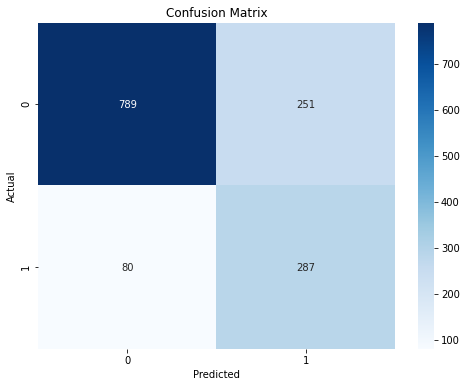

In [50]:
conf_matrix_cb = confusion_matrix(y_test, y_pred_cb > 0.5)

# Построение тепловой карты
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_cb, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

В верхней левой ячейке (789) указано количество верно предсказанных негативных случаев (True Negatives).  
В верхней правой ячейке (251) указано количество неверно предсказанных положительных случаев (False Positives).  
В нижней левой ячейке (80) указано количество неверно предсказанных негативных случаев (False Negatives).  
В нижней правой ячейке (287) указано количество верно предсказанных положительных случаев (True Positives).



TotalCharges: 21.3661
Type_Two year: 19.4137
Used: 11.7348
MonthlyCharges: 10.2537
Type_One year: 7.6783
InternetService_Fiber optic: 6.7687
InternetService_no: 5.0842
PaymentMethod_Electronic check: 3.2350
PaperlessBilling: 2.0136
StreamingMovies: 1.9139
TechSupport: 1.7410
MultipleLines: 1.4683
StreamingTV: 1.1795
SeniorCitizen: 1.1711
OnlineSecurity: 1.0553
Dependents: 0.8822
gender_Male: 0.7232
PaymentMethod_Mailed check: 0.6020
PaymentMethod_Credit card (automatic): 0.5931
DeviceProtection: 0.5280
OnlineBackup: 0.4867
Partner: 0.1077


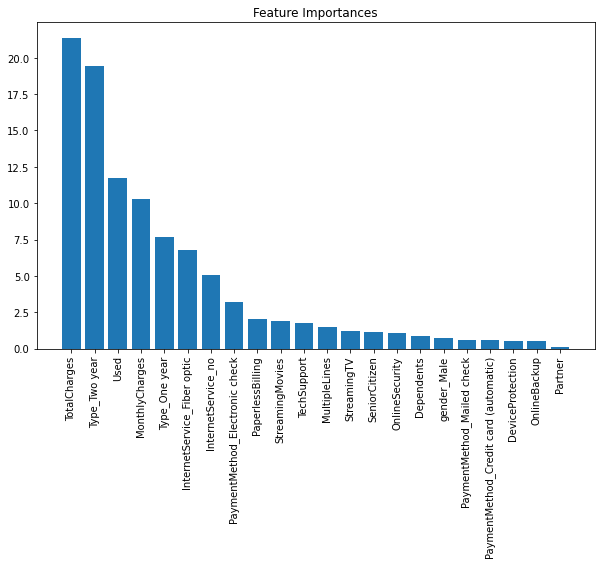

In [51]:
importances = best_catboost_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Вывод важности признаков
for i in range(X_train_encoded.shape[1]):
    print(f"{X_train_encoded.columns[indices[i]]}: {importances[indices[i]]:.4f}")

# Построение графика важности признаков
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train_encoded.shape[1]), importances[indices])
plt.xticks(range(X_train_encoded.shape[1]), X_train_encoded.columns[indices], rotation=90)
plt.show()

Значения важности для каждого признака, отсортированные в порядке убывания. Это позволяет увидеть, какие признаки оказывают наибольшее влияние на принятие решений моделью "TotalCharges", "Type_Month-to-month" и "Used" оказываются среди наиболее важных признаков для модели.

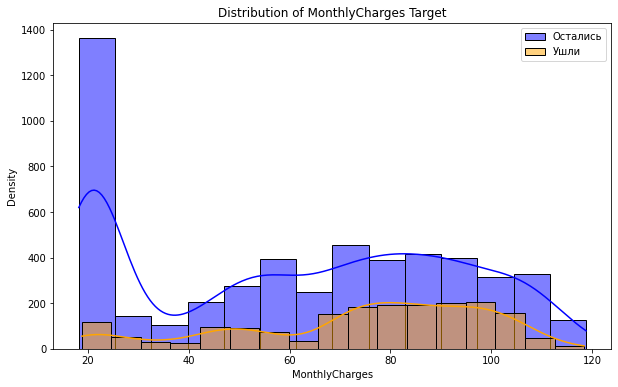

In [52]:
churn_df = df[df['Target'] == 1]
not_churn_df = df[df['Target'] == 0]

# Выбор одного из важных признаков (например, 'MonthlyCharges')
selected_feature = 'MonthlyCharges'

# Построение гистограмм распределения признака для каждого класса
plt.figure(figsize=(10, 6))
sns.histplot(data=not_churn_df, x=selected_feature, label='Оcтались', color='blue', kde=True)
sns.histplot(data=churn_df, x=selected_feature, label='Ушли', color='orange', kde=True)
plt.xlabel(selected_feature)
plt.ylabel('Density')
plt.title(f'Distribution of {selected_feature} Target')
plt.legend()
plt.show()

# Выводы

Была проведена предобработка и алнализх данных, так же обучено 3 типа моделей:
Лес
КэтБуст
Нейронная сеть
Наилучший результат показал случайный лес, после прогона модели на тестовых данных мы полуичли результат `roc_auc = 0.85`
Так же проанализировали важности признаков для обучения моделей